In [34]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

sns.set_palette('Set2')
%matplotlib inline

endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res_BTC = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1500')
res_LTC = requests.get(endpoint + '?fsym=LTC&tsym=USD&limit=1500')
hist_BTC = pd.DataFrame(json.loads(res_BTC.content)['Data'])
hist_BTC = hist_BTC.set_index('time')
hist_BTC.index = pd.to_datetime(hist_BTC.index, unit='s')
hist_LTC = pd.DataFrame(json.loads(res_LTC.content)['Data'])
hist_LTC = hist_LTC.set_index('time')
hist_LTC.index = pd.to_datetime(hist_LTC.index, unit='s')

hist_LTC.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2015-01-23,1.43,1.43,1.36,1.41,574629.55,808739.09
2015-01-24,1.86,1.88,1.41,1.43,645287.26,1030792.01
2015-01-25,2.22,2.39,1.83,1.86,786143.16,1679424.75
2015-01-26,2.06,2.37,2.02,2.22,1346812.41,2988557.23
2015-01-27,2.08,2.18,1.88,2.06,741466.24,1498406.05


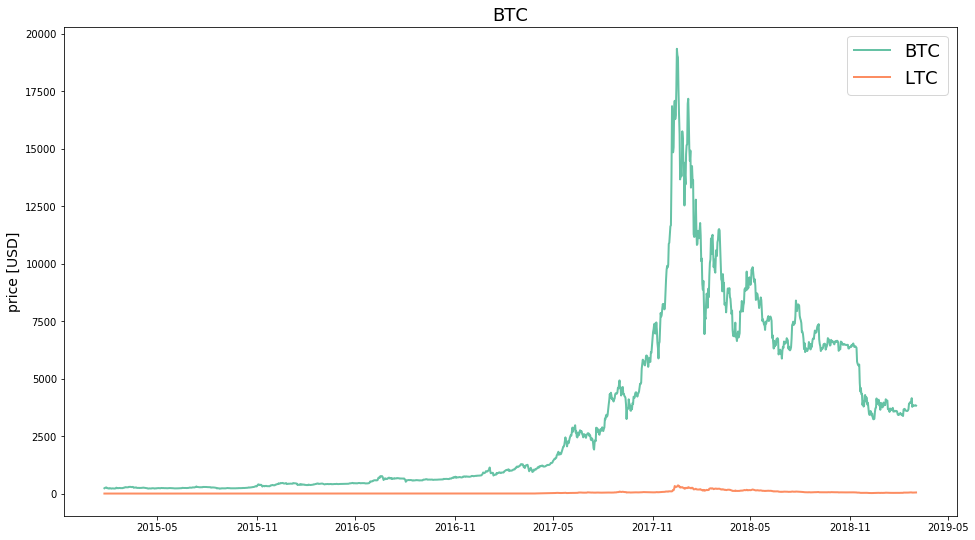

In [35]:
target_col = 'close'

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
   fig, ax = plt.subplots(1, figsize=(16, 9))
   ax.plot(line1, label=label1, linewidth=lw)
   ax.plot(line2, label=label2, linewidth=lw)
   ax.set_ylabel('price [USD]', fontsize=14)
   ax.set_title(title, fontsize=18)
   ax.legend(loc='best', fontsize=18)

line_plot(hist_BTC[target_col], hist_LTC[target_col], 'BTC', 'LTC', title='BTC')


### Key Getaway from the plot above:
1. just one continuing increase and one continuing decrease. model is not able to learn anthing from a past behavior like this
2. we need to do some feature engineering for the OHLC prices of cryptocurrencies

### Our Strategy:
__Convert the time series into a more stationary time series so the model can learn better from it__

### How to convert?
 - __Differencing:__ one common strategy is to use price of x(t) - x(t-1) to convert a nonstationary into a stationary time series
 - __Differencing with other assets:__another strategy is to calculate the price difference of 2 coins (since they are similar assets, so we assume they have similar behaviors) to get stationary time series
 - __Decomposing:__ decompose time series into trend, seasonal, and residual. we use residual to predict


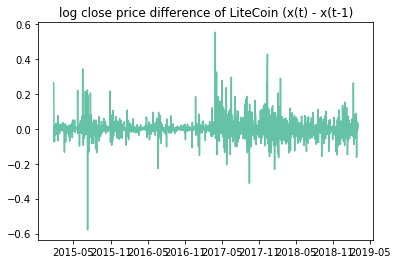

In [73]:
s_test = np.log(hist_LTC[target_col]) # we use log price
s1 = s_test - s_test.shift()
s1 = s1.dropna()
plt.plot(s1)
plt.title('log close price difference of LiteCoin (x(t) - x(t-1)')
plt.show()

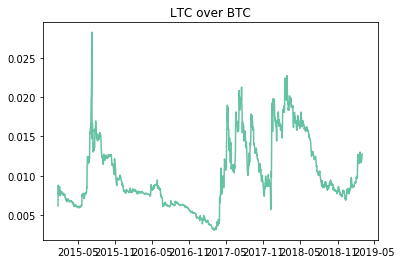

In [57]:
s2 = hist_LTC[target_col]/hist_BTC[target_col]
#s2 = hist_BTC[target_col]/hist_LTC[target_col]
plt.plot(s2)
plt.title('LTC over BTC')
plt.show()

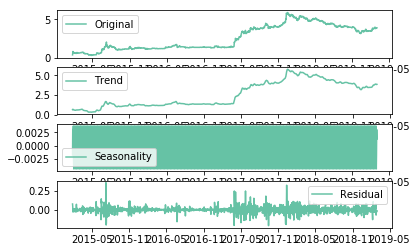

In [69]:
s3 = np.log(hist_LTC[target_col]) # we use log price

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(s3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(s3, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

__even the residual looks stationary, but we think it is hard to handle the trend data, so we decide to test the stationarity for only first 2 methods__
### Check for stationarity for above first 2 strategies

 - It is easier when the time series is stationary: 
 - __Augmented Dickey - Fuller test__ is commonly used to check stationarity in a time series.
 - Stationarity is an important property to make sure what happened in the past is more likely to repeat in the future

In [58]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

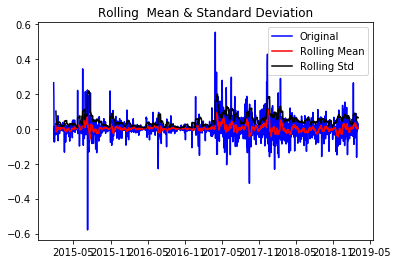

Results of Dickey-Fuller Test:
Test Statistic                -1.319270e+01
p-value                        1.135554e-24
#Lags Used                     7.000000e+00
Number of Observations Used    1.492000e+03
Critical Value (5%)           -2.863479e+00
Critical Value (1%)           -3.434740e+00
Critical Value (10%)          -2.567802e+00
dtype: float64


In [62]:
test_stationarity(s1)

### Takeaway from above:
 - the p-value is way below 0.05, so we can say it is a stationary time series

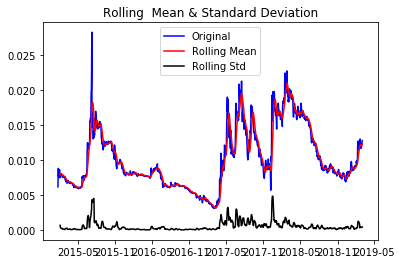

Results of Dickey-Fuller Test:
Test Statistic                   -2.399996
p-value                           0.141738
#Lags Used                       24.000000
Number of Observations Used    1476.000000
Critical Value (5%)              -2.863500
Critical Value (1%)              -3.434788
Critical Value (10%)             -2.567814
dtype: float64


In [65]:
test_stationarity(s2)

### Takeaway:
 - the p-value is 0.14, so we are not able to reject the H0, and the time series is non-stationary
 - we might use method one (differencing) to feed into model to do prediction

# What kind of potential trading strategy we can possibly use from predicting this time series

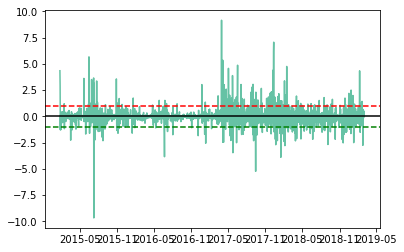

In [74]:
# first we standardize s1
def standardize(series):
    return (series - series.mean()) /np.std(series)

plt.plot(standardize(s1))
plt.axhline(standardize(s1).mean(),color = 'black')
plt.axhline(1.0,color = 'red',linestyle = '--')
plt.axhline(-1.0,color = 'green',linestyle = '--')

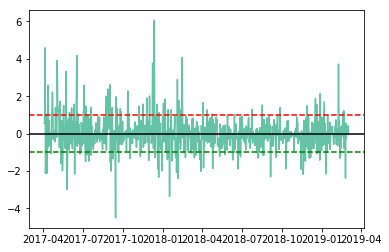

In [75]:
s_recent = s1[-700:]
plt.plot(standardize(s_recent))
plt.axhline(standardize(s_recent).mean(),color = 'black')
plt.axhline(1.0,color = 'red',linestyle = '--')
plt.axhline(-1.0,color = 'green',linestyle = '--')

### Take a look of the day-level data of the most recent 2 years
 - after standadization, for most of the time, the stationary time series fluctuates between upperbound of 1, and lowerbound of -1
 - whenever it goes higher than 1, it will soon come back to be within